In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
from PIL import Image
import tensorflow as tf
%matplotlib inline

from distutils.version import LooseVersion

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

TensorFlow Version: 1.0.0


In [2]:
from tqdm import tqdm
from os.path import isfile
from urllib.request import urlretrieve

image_data = "data_road.zip"

import zipfile

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(image_data):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='other data') as pbar:
        urlretrieve(
            'https://s3.eu-central-1.amazonaws.com/avg-kitti/data_road.zip',
            image_data,
            pbar.hook)
print('Extracting data ...')
zip_ref = zipfile.ZipFile('data_road.zip', 'r')
zip_ref.extractall(".")
zip_ref.close()

Extracting data ...


In [3]:
def DisplayImage(img1, img2, title1, title2):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.imshow(img1)
    ax1.set_title(title1, fontsize=10)
    ax2.imshow(img2)
    ax2.set_title(title2, fontsize=10)

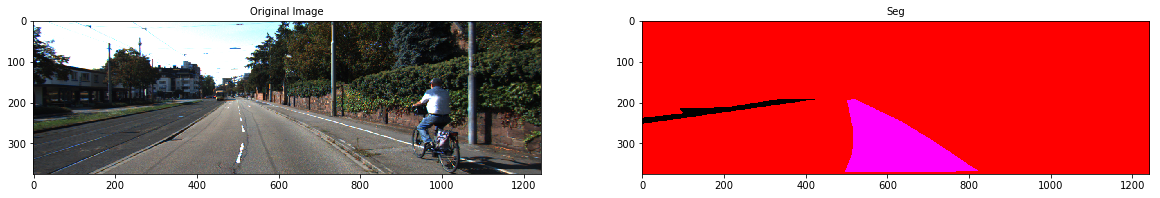

In [4]:
img = mpimg.imread('data_road/training/image_2/um_000000.png')
img2 = mpimg.imread('data_road/training/gt_image_2/um_lane_000000.png')
DisplayImage(img, img2, 'Original Image', 'Seg')

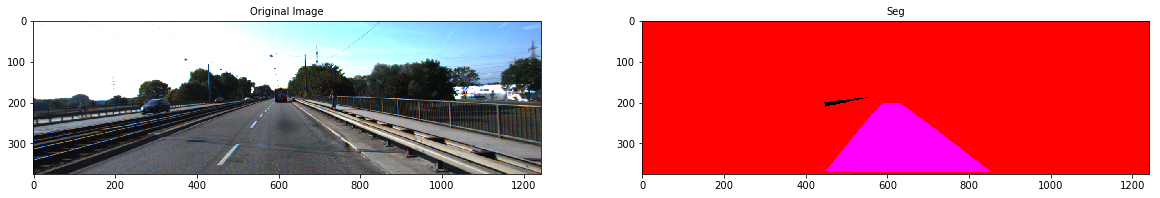

In [5]:
img = mpimg.imread('data_road/training/image_2/um_000080.png')
img2 = mpimg.imread('data_road/training/gt_image_2/um_lane_000080.png')
DisplayImage(img, img2, 'Original Image', 'Seg')

In [6]:
import os.path
import zipfile
import shutil

def maybe_download_pretrained_vgg(data_dir):
    """
    Download and extract pretrained vgg model if it doesn't exist
    :param data_dir: Directory to download the model to
    """
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))

        
def FCN(sess, num_classes, path = "."):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    
    # inner function
    def load_vgg(sess, vgg_path):
        """
        Load Pretrained VGG Model into TensorFlow.
        :param sess: TensorFlow Session
        :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
        :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
        """
        vgg_tag = 'vgg16'
        tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
        image_input = tf.get_default_graph().get_tensor_by_name('image_input:0')
        keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
        layer3_out = tf.get_default_graph().get_tensor_by_name('layer3_out:0')
        layer4_out = tf.get_default_graph().get_tensor_by_name('layer4_out:0')
        layer7_out = tf.get_default_graph().get_tensor_by_name('layer7_out:0')

        return image_input, keep_prob, layer3_out, layer4_out, layer7_out    
    
    maybe_download_pretrained_vgg(path)
    vgg_path = os.path.join(path, 'vgg')
    image_input, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)
    
    kernel_regularizer = tf.contrib.layers.l2_regularizer(1e-3)
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()
    
    conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1, padding = 'SAME',
                                kernel_initializer=kernel_initializer)
    conv_pool4 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1, padding = 'SAME',
                                  kernel_initializer=kernel_initializer)
    conv_pool3 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 1, padding = 'SAME',
                                  kernel_initializer=kernel_initializer)

    deconv_1 = tf.layers.conv2d_transpose(conv_1x1, num_classes, (4, 4), (2, 2), padding = 'SAME', 
                                          kernel_initializer=kernel_initializer)

    skip_layer1 = tf.add(deconv_1, conv_pool4)

    deconv_2 = tf.layers.conv2d_transpose(skip_layer1, num_classes, (4, 4), (2, 2), padding='SAME', 
                                          kernel_initializer=kernel_initializer)
    skip_layer2 = tf.add(deconv_2, conv_pool3)

    #Final deconvolution layer - kernel size 16,16 and stride - 8,8
    deconv_3 = tf.layers.conv2d_transpose(skip_layer2, num_classes, (16,16), strides=(8, 8), padding='SAME', 
                                          kernel_initializer=kernel_initializer)

    return deconv_3, image_input, keep_prob

In [7]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=correct_label))
    train_op = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy_loss)
    
    return logits, train_op, cross_entropy_loss

In [8]:
def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    sess.run(tf.global_variables_initializer())
    loss_per_epoch = []
    for epoch in range(epochs):
        losses, i = [], 0
        for images, labels in get_batches_fn(batch_size):
            i += 1
            feed_dict = {input_image: images, 
                         correct_label: labels, 
                         keep_prob: KEEP_PROB, 
                         learning_rate: LEARNING_RATE}
            _, loss = sess.run([train_op, cross_entropy_loss], feed_dict=feed_dict)
            losses.append(loss)
        
        training_loss = sum(losses) / len(losses)
        loss_per_epoch.append(training_loss)
        print(" [-] epoch: %d/%d, loss: %.5f" % (epoch+1, epochs, training_loss))
    return loss_per_epoch

In [9]:
def gen_batch_function(data_folder, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        label_paths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
            
    return get_batches_fn


In [10]:
def save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'data_road/testing'), image_shape)
    for name, image in image_outputs:
        scipy.misc.imsave(os.path.join(output_dir, name), image)

In [15]:
def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    vgg_tag = 'vgg16'
    tf.saved_model.loader.load(sess, [vgg_tag], vgg_path)
    image_input = tf.get_default_graph().get_tensor_by_name('image_input:0')
    keep_prob = tf.get_default_graph().get_tensor_by_name('keep_prob:0')
    layer3_out = tf.get_default_graph().get_tensor_by_name('layer3_out:0')
    layer4_out = tf.get_default_graph().get_tensor_by_name('layer4_out:0')
    layer7_out = tf.get_default_graph().get_tensor_by_name('layer7_out:0')

    return image_input, keep_prob, layer3_out, layer4_out, layer7_out    

In [19]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    
    kernel_regularizer = tf.contrib.layers.l2_regularizer(1e-3)
    kernel_initializer = tf.contrib.layers.xavier_initializer_conv2d()
    
    conv_1x1 = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 1, padding = 'SAME',
                                kernel_initializer=kernel_initializer)
    conv_pool4 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 1, padding = 'SAME',
                                  kernel_initializer=kernel_initializer)
    conv_pool3 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 1, padding = 'SAME',
                                  kernel_initializer=kernel_initializer)

    deconv_1 = tf.layers.conv2d_transpose(conv_1x1, num_classes, (4, 4), (2, 2), padding = 'SAME', 
                                          kernel_initializer=kernel_initializer)

    skip_layer1 = tf.add(deconv_1, conv_pool4)

    deconv_2 = tf.layers.conv2d_transpose(skip_layer1, num_classes, (4, 4), (2, 2), padding='SAME', 
                                          kernel_initializer=kernel_initializer)
    skip_layer2 = tf.add(deconv_2, conv_pool3)

    #Final deconvolution layer - kernel size 16,16 and stride - 8,8
    deconv_3 = tf.layers.conv2d_transpose(skip_layer2, num_classes, (16,16), strides=(8, 8), padding='SAME', 
                                          kernel_initializer=kernel_initializer)

    return deconv_3

In [21]:
import project_tests as tests
import helper

num_classes = 2
image_shape = (160, 576)
data_dir = './data'
runs_dir = './runs'
tests.test_for_kitti_dataset(data_dir)

# Download pretrained vgg model
helper.maybe_download_pretrained_vgg(data_dir)

# OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
# You'll need a GPU with at least 10 teraFLOPS to train on.
#  https://www.cityscapes-dataset.com/

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.85
config.gpu_options.allow_growth = True
sess = tf.InteractiveSession(config=config)

# Path to vgg model
vgg_path = os.path.join(data_dir, 'vgg')
# Create function to get batches
get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

# OPTIONAL: Augment Images for better results
#  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

# TODO: Build NN using load_vgg, layers, and optimize function
image_input, keep_prob, layer3, layer4, layer7 = load_vgg(sess, vgg_path)
out = layers(layer3, layer4, layer7, num_classes)

correct_label = tf.placeholder(tf.int32)
learning_rate = tf.placeholder(tf.float32)
logits, train_op, cross_entropy_loss = optimize(out, correct_label, learning_rate, num_classes)

# TODO: Train NN using the train_nn function
epochs = 30
batch_size = 10
loss_per_epoch = train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, image_input, 
                          correct_label, keep_prob, learning_rate)

Tests Passed


NameError: name 'KEEP_PROB' is not defined

In [ ]:
# TODO: Save inference data using helper.save_inference_samples
#  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)
helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, image_input)

# OPTIONAL: Apply the trained model to a video

In [ ]:
import sys
from copy import deepcopy
from unittest import mock

class TmpMock(object):
    """
    Mock a attribute.  Restore attribute when exiting scope.
    """
    def __init__(self, module, attrib_name):
        self.original_attrib = deepcopy(getattr(module, attrib_name))
        setattr(module, attrib_name, mock.MagicMock())
        self.module = module
        self.attrib_name = attrib_name

    def __enter__(self):
        return getattr(self.module, self.attrib_name)

    def __exit__(self, type, value, traceback):
        setattr(self.module, self.attrib_name, self.original_attrib)

def test_safe(func):
    """
    Isolate tests
    """
    def func_wrapper(*args):
        with tf.Graph().as_default():
            result = func(*args)
        print('Tests Passed')
        return result

    return func_wrapper

def _prevent_print(function, params):
    sys.stdout = open(os.devnull, "w")
    function(**params)
    sys.stdout = sys.__stdout__

def _assert_tensor_shape(tensor, shape, display_name):
    assert tf.assert_rank(tensor, len(shape), message='{} has wrong rank'.format(display_name))

    tensor_shape = tensor.get_shape().as_list() if len(shape) else []

    wrong_dimension = [ten_dim for ten_dim, cor_dim in zip(tensor_shape, shape)
                       if cor_dim is not None and ten_dim != cor_dim]
    assert not wrong_dimension, '{} has wrong shape.  Found {}'.format(display_name, tensor_shape)

@test_safe
def test_load_vgg(load_vgg, tf_module):
    with TmpMock(tf_module.saved_model.loader, 'load') as mock_load_model:
        vgg_path = ''
        sess = tf.Session()
        test_input_image = tf.placeholder(tf.float32, name='image_input')
        test_keep_prob = tf.placeholder(tf.float32, name='keep_prob')
        test_vgg_layer3_out = tf.placeholder(tf.float32, name='layer3_out')
        test_vgg_layer4_out = tf.placeholder(tf.float32, name='layer4_out')
        test_vgg_layer7_out = tf.placeholder(tf.float32, name='layer7_out')

        input_image, keep_prob, vgg_layer3_out, vgg_layer4_out, vgg_layer7_out = load_vgg(sess, vgg_path)

        assert mock_load_model.called, \
            'tf.saved_model.loader.load() not called'
        assert mock_load_model.call_args == mock.call(sess, ['vgg16'], vgg_path), \
            'tf.saved_model.loader.load() called with wrong arguments.'

        assert input_image == test_input_image, 'input_image is the wrong object'
        assert keep_prob == test_keep_prob, 'keep_prob is the wrong object'
        assert vgg_layer3_out == test_vgg_layer3_out, 'layer3_out is the wrong object'
        assert vgg_layer4_out == test_vgg_layer4_out, 'layer4_out is the wrong object'
        assert vgg_layer7_out == test_vgg_layer7_out, 'layer7_out is the wrong object'
        
        
@test_safe
def test_layers(layers):
    num_classes = 2
    vgg_layer3_out = tf.placeholder(tf.float32, [None, None, None, 256])
    vgg_layer4_out = tf.placeholder(tf.float32, [None, None, None, 512])
    vgg_layer7_out = tf.placeholder(tf.float32, [None, None, None, 4096])
    layers_output = layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes)

    _assert_tensor_shape(layers_output, [None, None, None, num_classes], 'Layers Output')
    
    
    
@test_safe
def test_optimize(optimize):
    num_classes = 2
    shape = [2, 3, 4, num_classes]
    layers_output = tf.Variable(tf.zeros(shape))
    correct_label = tf.placeholder(tf.float32, [None, None, None, num_classes])
    learning_rate = tf.placeholder(tf.float32)
    logits, train_op, cross_entropy_loss = optimize(layers_output, correct_label, learning_rate, num_classes)

    _assert_tensor_shape(logits, [2*3*4, num_classes], 'Logits')

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        sess.run([train_op], {correct_label: np.arange(np.prod(shape)).reshape(shape), learning_rate: 10})
        test, loss = sess.run([layers_output, cross_entropy_loss], {correct_label: np.arange(np.prod(shape)).reshape(shape)})

    assert test.min() != 0 or test.max() != 0, 'Training operation not changing weights.'


@test_safe
def test_train_nn(train_nn):
    epochs = 1
    batch_size = 2

    def get_batches_fn(batach_size_parm):
        shape = [batach_size_parm, 2, 3, 3]
        return np.arange(np.prod(shape)).reshape(shape)

    train_op = tf.constant(0)
    cross_entropy_loss = tf.constant(10.11)
    input_image = tf.placeholder(tf.float32, name='input_image')
    correct_label = tf.placeholder(tf.float32, name='correct_label')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate')
    with tf.Session() as sess:
        parameters = {
            'sess': sess,
            'epochs': epochs,
            'batch_size': batch_size,
            'get_batches_fn': get_batches_fn,
            'train_op': train_op,
            'cross_entropy_loss': cross_entropy_loss,
            'input_image': input_image,
            'correct_label': correct_label,
            'keep_prob': keep_prob,
            'learning_rate': learning_rate}
        _prevent_print(train_nn, parameters)

In [ ]:

test_load_vgg(load_vgg, tf)

In [ ]:
def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer7_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer3_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    # 1x1 convolution of vgg layer 7
    layer7a_out = tf.layers.conv2d(vgg_layer7_out, num_classes, 1, 
                                   padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01),
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # upsample
    layer4a_in1 = tf.layers.conv2d_transpose(layer7a_out, num_classes, 4, 
                                             strides= (2, 2), 
                                             padding= 'same', 
                                             kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # make sure the shapes are the same!
    # 1x1 convolution of vgg layer 4
    layer4a_in2 = tf.layers.conv2d(vgg_layer4_out, num_classes, 1, 
                                   padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # skip connection (element-wise addition)
    layer4a_out = tf.add(layer4a_in1, layer4a_in2)
    # upsample
    layer3a_in1 = tf.layers.conv2d_transpose(layer4a_out, num_classes, 4,  
                                             strides= (2, 2), 
                                             padding= 'same', 
                                             kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                             kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # 1x1 convolution of vgg layer 3
    layer3a_in2 = tf.layers.conv2d(vgg_layer3_out, num_classes, 1, 
                                   padding= 'same', 
                                   kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                   kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    # skip connection (element-wise addition)
    layer3a_out = tf.add(layer3a_in1, layer3a_in2)
    # upsample
    nn_last_layer = tf.layers.conv2d_transpose(layer3a_out, num_classes, 16,  
                                               strides= (8, 8), 
                                               padding= 'same', 
                                               kernel_initializer= tf.random_normal_initializer(stddev=0.01), 
                                               kernel_regularizer= tf.contrib.layers.l2_regularizer(1e-3))
    return nn_last_layer


In [ ]:
test_layers(layers)

In [ ]:
def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    # make logits a 2D tensor where each row represents a pixel and each column a class
    logits = tf.reshape(nn_last_layer, (-1, num_classes))
    correct_label = tf.reshape(correct_label, (-1,num_classes))
    # define loss function
    cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits= logits, labels= correct_label))
    # define training operation
    optimizer = tf.train.AdamOptimizer(learning_rate= learning_rate)
    train_op = optimizer.minimize(cross_entropy_loss)

    return logits, train_op, cross_entropy_loss

def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    sess.run(tf.global_variables_initializer())
    
    print("Training...")
    print()
    for i in range(epochs):
        print("EPOCH {} ...".format(i+1))
        for image, label in get_batches_fn(batch_size):
            _, loss = sess.run([train_op, cross_entropy_loss], 
                               feed_dict={input_image: image, correct_label: label, keep_prob: 0.5, learning_rate: 0.0009})
            print("Loss: = {:.3f}".format(loss))
    print()

In [ ]:
test_optimize(optimize)

In [ ]:
test_train_nn(train_nn)

In [ ]:
import os.path
import tensorflow as tf
import helper
import warnings
from distutils.version import LooseVersion
import project_tests as tests


# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))


def load_vgg(sess, vgg_path):
    """
    Load Pretrained VGG Model into TensorFlow.
    :param sess: TensorFlow Session
    :param vgg_path: Path to vgg folder, containing "variables/" and "saved_model.pb"
    :return: Tuple of Tensors from VGG model (image_input, keep_prob, layer3_out, layer4_out, layer7_out)
    """
    # TODO: Implement function
    #   Use tf.saved_model.loader.load to load the model and weights
    vgg_tag = 'vgg16'
    vgg_input_tensor_name = 'image_input:0'
    vgg_keep_prob_tensor_name = 'keep_prob:0'
    vgg_layer3_out_tensor_name = 'layer3_out:0'
    vgg_layer4_out_tensor_name = 'layer4_out:0'
    vgg_layer7_out_tensor_name = 'layer7_out:0'
    
    return None, None, None, None, None
tests.test_load_vgg(load_vgg, tf)


def layers(vgg_layer3_out, vgg_layer4_out, vgg_layer7_out, num_classes):
    """
    Create the layers for a fully convolutional network.  Build skip-layers using the vgg layers.
    :param vgg_layer3_out: TF Tensor for VGG Layer 3 output
    :param vgg_layer4_out: TF Tensor for VGG Layer 4 output
    :param vgg_layer7_out: TF Tensor for VGG Layer 7 output
    :param num_classes: Number of classes to classify
    :return: The Tensor for the last layer of output
    """
    # TODO: Implement function
    return None
tests.test_layers(layers)


def optimize(nn_last_layer, correct_label, learning_rate, num_classes):
    """
    Build the TensorFLow loss and optimizer operations.
    :param nn_last_layer: TF Tensor of the last layer in the neural network
    :param correct_label: TF Placeholder for the correct label image
    :param learning_rate: TF Placeholder for the learning rate
    :param num_classes: Number of classes to classify
    :return: Tuple of (logits, train_op, cross_entropy_loss)
    """
    # TODO: Implement function
    return None, None, None
tests.test_optimize(optimize)


def train_nn(sess, epochs, batch_size, get_batches_fn, train_op, cross_entropy_loss, input_image,
             correct_label, keep_prob, learning_rate):
    """
    Train neural network and print out the loss during training.
    :param sess: TF Session
    :param epochs: Number of epochs
    :param batch_size: Batch size
    :param get_batches_fn: Function to get batches of training data.  Call using get_batches_fn(batch_size)
    :param train_op: TF Operation to train the neural network
    :param cross_entropy_loss: TF Tensor for the amount of loss
    :param input_image: TF Placeholder for input images
    :param correct_label: TF Placeholder for label images
    :param keep_prob: TF Placeholder for dropout keep probability
    :param learning_rate: TF Placeholder for learning rate
    """
    # TODO: Implement function
    pass
tests.test_train_nn(train_nn)


def run():
    num_classes = 2
    image_shape = (160, 576)
    data_dir = './data'
    runs_dir = './runs'
    tests.test_for_kitti_dataset(data_dir)

    # Download pretrained vgg model
    helper.maybe_download_pretrained_vgg(data_dir)

    # OPTIONAL: Train and Inference on the cityscapes dataset instead of the Kitti dataset.
    # You'll need a GPU with at least 10 teraFLOPS to train on.
    #  https://www.cityscapes-dataset.com/

    with tf.Session() as sess:
        # Path to vgg model
        vgg_path = os.path.join(data_dir, 'vgg')
        # Create function to get batches
        get_batches_fn = helper.gen_batch_function(os.path.join(data_dir, 'data_road/training'), image_shape)

        # OPTIONAL: Augment Images for better results
        #  https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network

        # TODO: Build NN using load_vgg, layers, and optimize function

        # TODO: Train NN using the train_nn function

        # TODO: Save inference data using helper.save_inference_samples
        #  helper.save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image)

        # OPTIONAL: Apply the trained model to a video


if __name__ == '__main__':
    run()

In [ ]:
import re
import random
import numpy as np
import os.path
import scipy.misc
import shutil
import zipfile
import time
import tensorflow as tf
from glob import glob
from urllib.request import urlretrieve
from tqdm import tqdm


class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num


def maybe_download_pretrained_vgg(data_dir):
    """
    Download and extract pretrained vgg model if it doesn't exist
    :param data_dir: Directory to download the model to
    """
    vgg_filename = 'vgg.zip'
    vgg_path = os.path.join(data_dir, 'vgg')
    vgg_files = [
        os.path.join(vgg_path, 'variables/variables.data-00000-of-00001'),
        os.path.join(vgg_path, 'variables/variables.index'),
        os.path.join(vgg_path, 'saved_model.pb')]

    missing_vgg_files = [vgg_file for vgg_file in vgg_files if not os.path.exists(vgg_file)]
    if missing_vgg_files:
        # Clean vgg dir
        if os.path.exists(vgg_path):
            shutil.rmtree(vgg_path)
        os.makedirs(vgg_path)

        # Download vgg
        print('Downloading pre-trained vgg model...')
        with DLProgress(unit='B', unit_scale=True, miniters=1) as pbar:
            urlretrieve(
                'https://s3-us-west-1.amazonaws.com/udacity-selfdrivingcar/vgg.zip',
                os.path.join(vgg_path, vgg_filename),
                pbar.hook)

        # Extract vgg
        print('Extracting model...')
        zip_ref = zipfile.ZipFile(os.path.join(vgg_path, vgg_filename), 'r')
        zip_ref.extractall(data_dir)
        zip_ref.close()

        # Remove zip file to save space
        os.remove(os.path.join(vgg_path, vgg_filename))


def gen_batch_function(data_folder, image_shape):
    """
    Generate function to create batches of training data
    :param data_folder: Path to folder that contains all the datasets
    :param image_shape: Tuple - Shape of image
    :return:
    """
    def get_batches_fn(batch_size):
        """
        Create batches of training data
        :param batch_size: Batch Size
        :return: Batches of training data
        """
        image_paths = glob(os.path.join(data_folder, 'image_2', '*.png'))
        label_paths = {
            re.sub(r'_(lane|road)_', '_', os.path.basename(path)): path
            for path in glob(os.path.join(data_folder, 'gt_image_2', '*_road_*.png'))}
        background_color = np.array([255, 0, 0])

        random.shuffle(image_paths)
        for batch_i in range(0, len(image_paths), batch_size):
            images = []
            gt_images = []
            for image_file in image_paths[batch_i:batch_i+batch_size]:
                gt_image_file = label_paths[os.path.basename(image_file)]

                image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)
                gt_image = scipy.misc.imresize(scipy.misc.imread(gt_image_file), image_shape)

                gt_bg = np.all(gt_image == background_color, axis=2)
                gt_bg = gt_bg.reshape(*gt_bg.shape, 1)
                gt_image = np.concatenate((gt_bg, np.invert(gt_bg)), axis=2)

                images.append(image)
                gt_images.append(gt_image)

            yield np.array(images), np.array(gt_images)
    return get_batches_fn


def gen_test_output(sess, logits, keep_prob, image_pl, data_folder, image_shape):
    """
    Generate test output using the test images
    :param sess: TF session
    :param logits: TF Tensor for the logits
    :param keep_prob: TF Placeholder for the dropout keep robability
    :param image_pl: TF Placeholder for the image placeholder
    :param data_folder: Path to the folder that contains the datasets
    :param image_shape: Tuple - Shape of image
    :return: Output for for each test image
    """
    for image_file in glob(os.path.join(data_folder, 'image_2', '*.png')):
        image = scipy.misc.imresize(scipy.misc.imread(image_file), image_shape)

        im_softmax = sess.run(
            [tf.nn.softmax(logits)],
            {keep_prob: 1.0, image_pl: [image]})
        im_softmax = im_softmax[0][:, 1].reshape(image_shape[0], image_shape[1])
        segmentation = (im_softmax > 0.5).reshape(image_shape[0], image_shape[1], 1)
        mask = np.dot(segmentation, np.array([[0, 255, 0, 127]]))
        mask = scipy.misc.toimage(mask, mode="RGBA")
        street_im = scipy.misc.toimage(image)
        street_im.paste(mask, box=None, mask=mask)

        yield os.path.basename(image_file), np.array(street_im)


def save_inference_samples(runs_dir, data_dir, sess, image_shape, logits, keep_prob, input_image):
    # Make folder for current run
    output_dir = os.path.join(runs_dir, str(time.time()))
    if os.path.exists(output_dir):
        shutil.rmtree(output_dir)
    os.makedirs(output_dir)

    # Run NN on test images and save them to HD
    print('Training Finished. Saving test images to: {}'.format(output_dir))
    image_outputs = gen_test_output(
        sess, logits, keep_prob, input_image, os.path.join(data_dir, 'data_road/testing'), image_shape)
    for name, image in image_outputs:
scipy.misc.imsave(os.path.join(output_dir, name), image)